In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 

feat_df = pd.read_csv("data/symmetric_model_features.csv")
feat_df["Date"] = pd.to_datetime(feat_df["Date"])
print(feat_df.shape)
feat_df.head()

(3888, 209)


,FighterID,OpponentID,oldFighterEloAD,oldOpponentEloAD,predTargetAD,targetAD,Date,newFighterEloAD,newOpponentEloAD,oldEloDiffAD,...,imp_height_opp,age,age_opp,age_diff,reach_diff,weight_diff,log_weight_diff,height_diff,log_t_since_last_fight,log_t_since_last_fight_opp
0,2335635/jason-delucia,2335757/trent-jenkins,0.0,0.0,0.0,1.000000,1993-11-12,0.20000,-0.20000,0.0,...,75.854283,NaN,NaN,0.0,-5.273051,-64.4375,-0.298069,-4.64658,6.593045,6.593045
1,2335738/gerard-gordeau,2504081/teila-tuli,0.0,0.0,0.0,0.000000,1993-11-12,0.00000,0.00000,0.0,...,75.854283,34.646575,NaN,0.0,0.000000,0.0000,0.000000,0.00000,6.593045,6.593045
2,2335728/zane-frazier,2504082/kevin-rosier,0.0,0.0,0.0,0.000000,1993-11-12,0.00000,0.00000,0.0,...,69.868379,27.345205,NaN,0.0,0.000000,0.0000,0.000000,0.00000,6.593045,6.593045
3,2335738/gerard-gordeau,2504082/kevin-rosier,0.0,0.0,0.0,0.000000,1993-11-12,0.00000,0.00000,0.0,...,69.868379,34.646575,NaN,0.0,0.000000,0.0000,0.000000,0.00000,6.593045,6.593045
4,2335635/jason-delucia,2951141/scott-baker,0.2,0.0,0.2,0.267949,1994-03-11,0.21359,-0.01359,0.2,...,75.854283,NaN,NaN,0.0,-5.273051,-64.4375,-0.298069,-4.64658,4.779123,6.593045


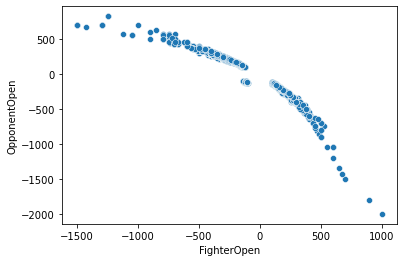

In [2]:
# i think this makes sense - hard to estimate a probability when the money is that imbalanced?
ml_df = pd.read_csv("data/clean_stats_plus_ml.csv")
ml_df["Date"] = pd.to_datetime(ml_df["Date"])
sns.scatterplot(x="FighterOpen", y="OpponentOpen", data=ml_df)
plt.show()

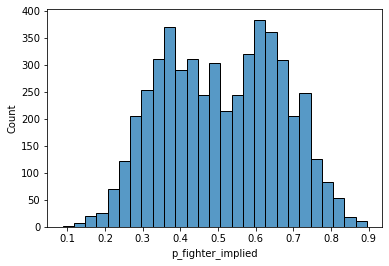

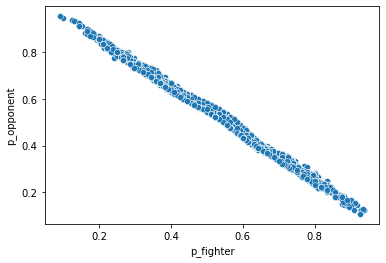

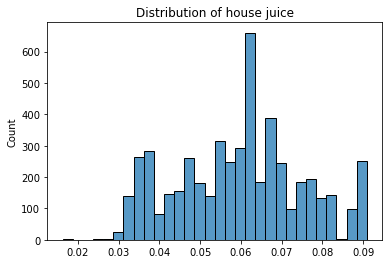

In [3]:
def parse_american_odds(x:pd.Series):
    fav_inds = x <= 0
    dog_inds = x > 0
    y = pd.Series(0, index=x.index)
    y.loc[fav_inds] = -1 * x / (100 - x)
    y.loc[dog_inds] = 100 / (100 + x)
    return y

ml_df["p_fighter"] = parse_american_odds(ml_df["FighterOpen"])
ml_df["p_opponent"] = parse_american_odds(ml_df["OpponentOpen"])
ml_df["p_fighter_midpoint"] = (ml_df["p_fighter"] + 1 - ml_df["p_opponent"]) / 2
ml_df["p_fighter_implied"] = ml_df["p_fighter"] / (ml_df["p_fighter"] + ml_df["p_opponent"])

sns.histplot(ml_df["p_fighter_implied"])
plt.show()

sns.scatterplot(x="p_fighter", y="p_opponent", data=ml_df)
plt.show()

sns.histplot(ml_df["p_fighter"] - (1 - ml_df["p_opponent"]))
plt.title("Distribution of house juice")
plt.show()

In [4]:
def get_fight_id_vec(df):
    fighter_A = df[["FighterID", "OpponentID"]].fillna("missing").max(1)
    fighter_B = df[["FighterID", "OpponentID"]].fillna("missing").min(1)
    fight_ids = df["Date"].astype(str) + "__" + fighter_A + "__" + fighter_B
    return fight_ids

ml_df["fight_id"] = get_fight_id_vec(ml_df)
feat_df["fight_id"] = get_fight_id_vec(feat_df)
feat_df["fight_id"].head()

0    1993-11-12__2335757/trent-jenkins__2335635/jas...
1    1993-11-12__2504081/teila-tuli__2335738/gerard...
2    1993-11-12__2504082/kevin-rosier__2335728/zane...
3    1993-11-12__2504082/kevin-rosier__2335738/gera...
4    1994-03-11__2951141/scott-baker__2335635/jason...
Name: fight_id, dtype: object

In [5]:
feat_ml_df = feat_df.merge(
    ml_df[[#"FighterID", "OpponentID", "Date", 
        "fight_id",
           "FighterOpen", "OpponentOpen", "p_fighter_implied",
           "p_fighter", "p_opponent", "p_fighter_midpoint"]],
    #on=["FighterID", "OpponentID", "Date"],
    on="fight_id",
    how="inner"
)
feat_ml_df.shape

(3220, 216)

<AxesSubplot:xlabel='ml_logit', ylabel='p_fighter_implied'>

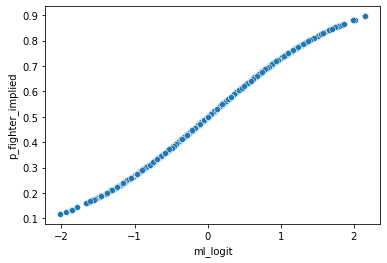

In [6]:
def logit(x):
    return np.log(x) - np.log(1-x)

feat_ml_df["ml_logit"] = logit(feat_ml_df["p_fighter_implied"])

sns.scatterplot(x="ml_logit", y="p_fighter_implied", data=feat_ml_df)

In [7]:
((feat_ml_df["ml_logit"] >= 0) == feat_ml_df["targetWin"]).mean()

0.6403726708074534

In [8]:
from sklearn.metrics import log_loss, accuracy_score

log_loss(y_pred=feat_ml_df["p_fighter_implied"], y_true=feat_ml_df["targetWin"])

0.6332568353320942

In [9]:
feat_cols = [
    "oldEloDiffordinal_fighter_result", 
    "oldEloDiffsubmission_fighter_result",
    "oldEloDifftko_ko_fighter_result",
    "oldEloDiffdecision_fighter_result",
    "oldEloDifffinish_fighter_result",
#     "oldEloDifffighter_result_time_left",
    
#     'oldEloDiffAD', 
    'oldEloDiffADTB', 
    'oldEloDiffADTM', 
    'oldEloDiffKD',
    'oldEloDiffRV', 
#     'oldEloDiffSCBL', 
#     'oldEloDiffSCHL', 
    'oldEloDiffSGBL',
    'oldEloDiffSGHL', 
    'oldEloDiffSM', 'oldEloDiffSSL', 'oldEloDiffTDL',
    'oldEloDiffTDS', 
    'oldEloDiffTD_fails', 
    'oldEloDiffTSL',
    'oldEloDiffclinch_strikes_landed', 
    'oldEloDiffdistance_strikes_landed',
    'oldEloDiffground_strikes_landed', 
    'oldEloDiffstanding_strikes',
    
    'oldEloDiffWin',
    
    "t_since_last_fight_log_diff", 
#     "t_since_last_fight_diff",
    "total_fights_sqrt_diff", 
    "total_ufc_fights_diff",
    
    "age_diff", "reach_diff", 
    "weight_diff", 
    "log_weight_diff",
    "height_diff",
]

feat_ml_df[feat_cols].isnull().any()
# min_train_dt = pd.to_datetime("2012-01-01")
min_train_dt = pd.to_datetime("2000-01-01")
max_train_dt = pd.to_datetime("2021-07-01")

train_inds = (feat_ml_df["Date"] <= max_train_dt) & (feat_ml_df["Date"] >= min_train_dt)
test_inds = (feat_ml_df["Date"] > max_train_dt)

train_df = feat_ml_df.loc[train_inds].dropna(subset=[*feat_cols, "targetWin"])
test_df = feat_ml_df.loc[test_inds].dropna(subset=[*feat_cols, "targetWin"])

X_train = train_df[feat_cols]
X_test = test_df[feat_cols]
ml_logit_train = train_df["ml_logit"]
ml_logit_test = test_df["ml_logit"]
y_train = train_df["targetWin"]
y_test = test_df["targetWin"]
X_train.shape, X_test.shape

((2888, 30), (331, 30))

SimpleSymmetricModel(
  (linear): Linear(in_features=30, out_features=1, bias=False)
  (softmax): Sigmoid()
)


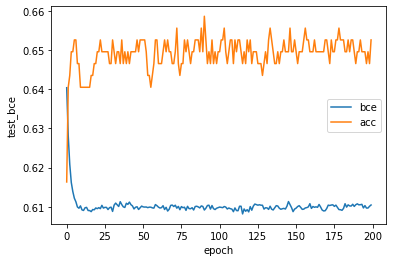

,train_acc,train_bce,test_acc,test_bce,epoch
115,0.656856,0.621462,0.646526,0.608161,115
119,0.659626,0.621413,0.649547,0.608682,119
109,0.656510,0.621408,0.646526,0.608736,109
148,0.656163,0.621440,0.649547,0.608743,148
16,0.652355,0.622552,0.643505,0.608745,16


In [10]:
import torch
from sklearn.utils import shuffle, gen_batches
from sklearn.preprocessing import StandardScaler

class SimpleSymmetricModel(torch.nn.Module):
    """
    Just symmetric logistic regression
    """
    
    def __init__(self, input_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, 1, bias=False)
        self.softmax = torch.nn.Sigmoid()
        
    def forward(self, ml_logit, x):
        x = self.linear(x)
        x = self.softmax(ml_logit + x)
        return x
    

class SymmetricModel(torch.nn.Module):
    
    def __init__(self, input_dim, width_1, width_2):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_dim, width_1, bias=False)
        self.activation = torch.nn.Tanh() # tanh(x) = -tanh(-x)
        self.linear2 = torch.nn.Linear(width_1, width_2, bias=False)
        self.linear3 = torch.nn.Linear(width_2, 1, bias=False)
#         self.linear3 = torch.nn.Linear(width_2, width_3, bias=False)
#         self.linear4 = torch.nn.Linear(width_3, 1, bias=False)
        self.softmax = torch.nn.Sigmoid()
        
    def forward(self, ml_logit, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
#         x = self.activation(x)
#         x = self.linear4(x)
        x = self.softmax(ml_logit + x)
        return x

# sym_model = SymmetricModel(len(feat_cols), 16, 16)
sym_model = SimpleSymmetricModel(len(feat_cols))
print(sym_model)

optimizer = torch.optim.Adam(sym_model.parameters(), lr=0.001)
batch_size = 64

loss_fn = torch.nn.BCELoss() # binary cross entropy
    
metric_vals = []

scaler = StandardScaler(with_mean=False)
scaled_X = scaler.fit_transform(train_df[feat_cols])
scaled_y = train_df["targetWin"].values
scaled_test_X = scaler.transform(test_df[feat_cols])

for epoch in range(200):
    # shuffle dataset
    shuffle_inds = shuffle(range(scaled_X.shape[0]))
    X_train = torch.Tensor(scaled_X[shuffle_inds,:])
    ml_train = torch.Tensor(ml_logit_train.iloc[shuffle_inds].values).view(-1,1)
    y_train = torch.Tensor(scaled_y[shuffle_inds]).view(-1,1)
    #y_train = torch.Tensor(train_df.iloc[shuffle_inds, "targetWin"].values).view(-1,1)
    for batch_inds in gen_batches(scaled_X.shape[0], batch_size):
        optimizer.zero_grad()
        y_hat = sym_model(ml_train[batch_inds], X_train[batch_inds])
        #print(ml_train[batch_inds].shape, y_train[batch_inds].shape, y_hat.shape)
        loss = loss_fn(y_hat, y_train[batch_inds])
        loss.backward()
        optimizer.step()
        
    y_hat = sym_model(ml_train, X_train)
    y_true = y_train
#     foo = torch.Tensor(ml_logit_train.values)
#     fee = torch.Tensor(scaled_X)
#     y_hat = sym_model(foo, fee)
#     y_true = torch.Tensor(train_df["targetWin"].values).view(-1, 1)
#     print(foo.shape, fee.shape)
    train_acc = (y_hat.round() == y_true).double().mean()
    train_bce = loss_fn(y_hat, y_true)
    
    y_hat = sym_model(torch.Tensor(ml_logit_test.values).view(-1,1), torch.Tensor(scaled_test_X))
    y_true = torch.Tensor(test_df["targetWin"].values).view(-1, 1)
    test_acc = (y_hat.round() == y_true).double().mean()
    test_bce = loss_fn(y_hat, y_true)
    
    metric_vals.append({
        "train_acc": float(train_acc),
        "train_bce": float(train_bce),
        "test_acc": float(test_acc),
        "test_bce": float(test_bce),
        "epoch": epoch,
    })
    
metric_df = pd.DataFrame(metric_vals)
sns.lineplot(x="epoch", y="test_bce", label="bce", data=metric_df)
sns.lineplot(x="epoch", y="test_acc", label="acc", data=metric_df)
plt.show()
metric_df.sort_values("test_bce").head()

In [11]:
metric_df["test_bce"].min()

0.6081610918045044

In [12]:
metric_df["test_acc"].max()

0.6586102719033232

In [13]:
log_loss(y_pred=test_df["p_fighter_implied"], y_true=test_df["targetWin"])

0.6169001683494999

In [14]:
accuracy_score(y_pred=test_df["p_fighter_implied"].round(), y_true=test_df["targetWin"])

0.649546827794562

<AxesSubplot:ylabel='Count'>

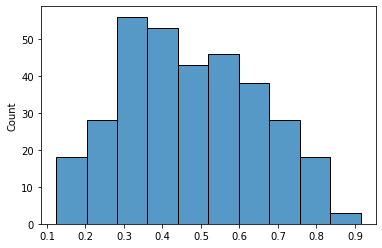

In [15]:
y_pred = sym_model(torch.Tensor(ml_logit_test.values).view(-1,1), 
                   torch.Tensor(scaled_test_X))
y_pred = (y_pred[:,0]).detach().numpy()
sns.histplot(y_pred)

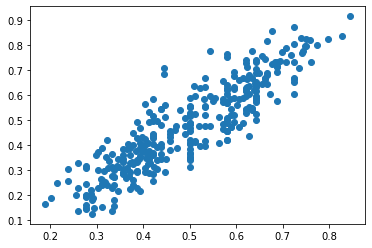

In [16]:
plt.scatter(test_df["p_fighter_implied"], y_pred)

In [17]:
log_loss(y_pred=y_pred, y_true=test_df["targetWin"])

0.6104390766145239

In [18]:
def eval_preds_dumb(y_pred, test_df):
    # bet a fixed amount on the predicted winner if I think it's profitable
    # I'll say that payout includes wager
    f_payout = 1/test_df["p_fighter"]
    o_payout = 1/test_df["p_opponent"]
    # expected return is positive
    f_bet = y_pred * f_payout > 1 
    o_bet = (1 - y_pred) * o_payout > 1
    print("number of bets on f:", f_bet.sum())
    print("number of bets on o:", o_bet.sum())
    print("number of bets on both f and o (should be zero):", (f_bet & o_bet).sum())
    print("% of fights i bet on at all: ", (f_bet | o_bet).mean())
    
    f_won = test_df["targetWin"] == 1
    o_won = test_df["targetWin"] == 0
    f_returns = f_bet * (f_payout * f_won - o_won)
    o_returns = o_bet * (o_payout * o_won - f_won)
    # TODO this HAS to be wrong...
    growth_rates = f_returns + o_returns + 1
    return np.mean(growth_rates)
    
eval_preds_dumb(y_pred, test_df)

number of bets on f: 103
number of bets on o: 162
number of bets on both f and o (should be zero): 0
% of fights i bet on at all:  0.8006042296072508


1.5190482330595523

In [19]:
def eval_kelly(y_pred, test_df):
    # b is % of wager gained on a win (not counting original wager)
    b_fighter = (1/test_df["p_fighter"]) - 1
    b_opponent = (1/test_df["p_opponent"]) - 1
    
    kelly_bet_fighter = y_pred + ((y_pred - 1) / b_fighter)
    kelly_bet_opponent = (1 - y_pred) + ((1 - y_pred - 1) / b_opponent)
    kelly_bet_fighter = np.maximum(0, kelly_bet_fighter)
    kelly_bet_opponent = np.maximum(0, kelly_bet_opponent)
    
    f_won = test_df["targetWin"] == 1
    o_won = test_df["targetWin"] == 0
    
    fighter_return = (kelly_bet_fighter * b_fighter * f_won) - (kelly_bet_fighter * o_won)
    opponent_return = (kelly_bet_opponent * b_opponent * o_won) - (kelly_bet_opponent * f_won)
    
    total_returns = 1 + fighter_return + opponent_return
    return np.prod(total_returns)

eval_kelly(y_pred, test_df)

1.2222329743371991

In [20]:
test_df["Date"].max() - test_df["Date"].min()

Timedelta('259 days 00:00:00')

# alright, so a 50% increase in money after 259 days. honestly not that bad.

I don't think I can directly compare the results of the $1 per bet vs the kelly criterion results. The Kelly criterion assumes a fixed bankroll. 

# Slightly more interesting architecture

In [21]:
opp_elo_cols = train_df.columns[train_df.columns.str.startswith("oldOpponentElo")]
fighter_elo_cols = ["oldFighter" + col[len("oldOpponent"):] for col in opp_elo_cols]
# fighter_elo_cols = train_df.columns[train_df.columns.str.startswith("oldFighterElo")]
opp_feat_cols = ['total_fights_opp', 'total_ufc_fights_opp', 
                 #'t_since_last_fight_opp',
                 'log_t_since_last_fight_opp',
                 'imp_reach_opp', 'imp_weight_opp', 'imp_height_opp', 
#                  'age_opp' # i'll figure out what to do with this later. have to impute
                ]
fighter_feat_cols = [col[:-len("_opp")] for col in opp_feat_cols]

fighter_cols = list(fighter_elo_cols) + fighter_feat_cols
opp_cols = list(opp_elo_cols) + opp_feat_cols

In [22]:
# oh geez so I need raw feature values for both the fighter and the opponent...
scaler = StandardScaler(with_mean=True, with_std=True)

temp_X = np.concatenate([train_df[fighter_cols], train_df[opp_cols]])
scaler.fit(temp_X)

X_f_scaled_train = scaler.transform(train_df[fighter_cols].values)
X_o_scaled_train = scaler.transform(train_df[opp_cols].values)

X_f_scaled_test = scaler.transform(test_df[fighter_cols].values)
X_o_scaled_test = scaler.transform(test_df[opp_cols].values)

n_train = X_f_scaled_train.shape[0]

X_f_scaled_train.shape, X_o_scaled_train.shape

((2888, 31), (2888, 31))

In [ ]:
for epoch in range(200):
    # shuffle dataset
    shuffle_inds = shuffle(range(scaled_X.shape[0]))
    X_train = torch.Tensor(scaled_X[shuffle_inds,:])
    ml_train = torch.Tensor(ml_logit_train.iloc[shuffle_inds].values).view(-1,1)
    y_train = torch.Tensor(scaled_y[shuffle_inds]).view(-1,1)
    #y_train = torch.Tensor(train_df.iloc[shuffle_inds, "targetWin"].values).view(-1,1)
    for batch_inds in gen_batches(scaled_X.shape[0], batch_size):
        optimizer.zero_grad()
        y_hat = sym_model(ml_train[batch_inds], X_train[batch_inds])
        #print(ml_train[batch_inds].shape, y_train[batch_inds].shape, y_hat.shape)
        loss = loss_fn(y_hat, y_train[batch_inds])
        loss.backward()
        optimizer.step()
        
    y_hat = sym_model(ml_train, X_train)
    y_true = y_train
#     foo = torch.Tensor(ml_logit_train.values)
#     fee = torch.Tensor(scaled_X)
#     y_hat = sym_model(foo, fee)
#     y_true = torch.Tensor(train_df["targetWin"].values).view(-1, 1)
#     print(foo.shape, fee.shape)
    train_acc = (y_hat.round() == y_true).double().mean()
    train_bce = loss_fn(y_hat, y_true)
    
    y_hat = sym_model(torch.Tensor(ml_logit_test.values).view(-1,1), torch.Tensor(scaled_test_X))


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 34.94it/s]


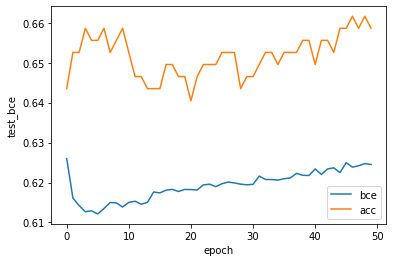

,train_acc,train_bce,test_acc,test_bce,epoch
5,0.644044,0.626362,0.655589,0.612141,5
3,0.644391,0.628443,0.658610,0.612696,3
4,0.645083,0.627327,0.655589,0.612908,4
6,0.646814,0.625840,0.658610,0.613494,6
9,0.650623,0.624426,0.658610,0.613870,9


In [29]:
from tqdm import tqdm 

class AugEloModel(torch.nn.Module):
    """
    Calculate embeddings for fighter and opponent, take the difference, plug into logistic reg
    Result should be guaranteed "symmetric" in the sense that f(x) = 1 - f(-x)
    """
    
    def __init__(self, input_dim, hidden_dim, embed_dim):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.activation = torch.nn.Tanh()
#         self.activation = torch.nn.ReLU() # tanh(x) = -tanh(-x)
        #self.activation = torch.nn.LeakyReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, embed_dim)
        # logistic regression on differences in embeddings 
        self.linear_on_embed = torch.nn.Linear(embed_dim, 1, bias=False)
        self.softmax = torch.nn.Sigmoid()
        
        
    def forward(self, ml_logit, fighter_x, opp_x):
        # get embeddings for fighter
        f_x = self.linear1(fighter_x)
        f_x = self.activation(f_x)
        f_x = self.linear2(f_x)
        f_x = self.activation(f_x)
        # get embeddings for opponent
        o_x = self.linear1(opp_x)
        o_x = self.activation(o_x)
        o_x = self.linear2(o_x)
        o_x = self.activation(o_x)
        # logistic regression on (f_embed - o_embed)
        diff_x = o_x - f_x
        #diff_x = f_x - o_x # hopefully torch knows what to do with this
        x = self.linear_on_embed(ml_logit + diff_x)
        x = self.softmax(x)
        return x
    
aug_model = AugEloModel(X_f_scaled_train.shape[1], 8, 8)

optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.001)
batch_size = 64

loss_fn = torch.nn.BCELoss() # binary cross entropy

metric_vals = []

for epoch in tqdm(range(50)):
    # shuffle dataset
    shuffle_inds = shuffle(range(n_train))
    
    ml_train = torch.Tensor(ml_logit_train.iloc[shuffle_inds].values).view(-1,1)
    X_f = torch.Tensor(X_f_scaled_train[shuffle_inds,:])
    X_o = torch.Tensor(X_o_scaled_train[shuffle_inds,:])
    y_train = torch.Tensor(train_df["targetWin"].values[shuffle_inds]).view(-1,1)

    for batch_inds in gen_batches(n_train, batch_size):
        optimizer.zero_grad()
        y_hat = aug_model(ml_train[batch_inds], X_f[batch_inds], X_o[batch_inds])
        loss = loss_fn(y_hat, y_train[batch_inds])
        loss.backward()
        optimizer.step()
        
    y_hat = aug_model(ml_train, X_f, X_o)
    y_true = y_train
    train_acc = (y_hat.round() == y_true).double().mean()
    train_bce = loss_fn(y_hat, y_true)
    
    ml_test = torch.Tensor(ml_logit_test.values).view(-1,1)
    X_f = torch.Tensor(X_f_scaled_test)
    X_o = torch.Tensor(X_o_scaled_test)
    y_hat = aug_model(ml_test, X_f, X_o)
    y_true = torch.Tensor(test_df["targetWin"].values).view(-1, 1)
    test_acc = (y_hat.round() == y_true).double().mean()
    test_bce = loss_fn(y_hat, y_true)
    
    metric_vals.append({
        "train_acc": float(train_acc),
        "train_bce": float(train_bce),
        "test_acc": float(test_acc),
        "test_bce": float(test_bce),
        "epoch": epoch,
    })
    
metric_df = pd.DataFrame(metric_vals)
sns.lineplot(x="epoch", y="test_bce", label="bce", data=metric_df)
sns.lineplot(x="epoch", y="test_acc", label="acc", data=metric_df)
plt.show()

metric_df.sort_values("test_bce").head()